<a href="https://colab.research.google.com/github/Youngmi-Park/Coursera-DeepLearning.AI-TensorFlow-Developer/blob/main/Course2/2_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using more sophisticated images with Convolutional Neural Networks

Kaggle  Dogs v Cats dataset: https://www.kaggle.com/c/dogs-vs-cats

첫 번째 Course에서는 TensorFlow를 사용하여 기본 신경망을 구현하는 방법을 배우고 기본 컨볼루션 신경망까지 구현해보았다.

두 번째 Course에서는 Kaggle 25,000마리의 고양이와 개 데이터셋에 적용해본다.

훨씬 더 큰 데이터 세트를 훈련하는 것이 어떤 것인지 살펴보고자한다. 특히 손글씨 인식은 모든 이미지의 크기와 모양을 동일하게 하고 모든 이미지를 모노크롬으로 하여 생활을 조금 더 편리하게 했다. 하지만, 실제 이미지는 그렇지 않다. 모양, 가로 세로 비율 등이 다르며 일반적으로 색상이 있다.

작은 데이터셋를 사용하면 과적합의 위험이 커진다. 더 큰 데이터 세트를 사용하면 과적합의 위험이 줄어들지만 과적합은 여전히 ​​발생할 수 있다.

인터넷에서 공개 데이터 세트를 다운로드하면 데이터가 엉망인 경우가 많다. 다른 데이터가 섞여있거나, 손상되었거나, 길이가 0인 일부 파일이 있을 수 있다.따라서 작업의 일부로 데이터를 처리해야 한다. 특히 모양이 균일하도록 크기를 조정해야 한다.

Tensorflow로 이러한 문제를 다뤄보자

1. 고양이와 개의 예제 데이터 탐색
2. 고양이와 개의 차이점을 인식하도록 신경망 구축 및 훈련
3. 훈련 및 검증 정확도 평가

## Explore the Example Data

폴더에 고양이 개 사진 2000장 예제 데이터를 다운로드한다.







In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-16 01:18:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   174MB/s    in 0.4s    

2022-01-16 01:18:05 (174 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!pwd

/content


In [3]:
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

zip파일은 `./cats_and_dogs_filterd`로 추출된다. 해당 파일은 train 데이터와 validation파일을 가지고 있다. 그리고 각각 각각 고양이와 개 하위 디렉토리를 포함하고 있다.

즉, 훈련 세트는 신경망 모델에 '이것이 고양이가 어떻게 생겼는지', '이것이 개가 어떻게 생겼는지' 등을 알려주고, 검증 데이터 세트는 이미지에 고양이 또는 개가 포함되어 있는지 평가할 때 신경망이 얼마나, 얼마나 나쁜지 테스트할 수 있다.

그리고 고양이, 개로 레이블을 지정하지않고 1과 7로 지정했다. 여기서 ImageGenerator를 사용하는데, 이는 이미지에 적절하게 레이블을 지정하여 코딩 단계를 줄인다.

In [5]:
base_dir = './cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
# 파일이름 확인해보기
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.475.jpg', 'cat.782.jpg', 'cat.757.jpg', 'cat.330.jpg', 'cat.672.jpg', 'cat.110.jpg', 'cat.861.jpg', 'cat.445.jpg', 'cat.175.jpg', 'cat.481.jpg']
['dog.673.jpg', 'dog.342.jpg', 'dog.278.jpg', 'dog.43.jpg', 'dog.926.jpg', 'dog.573.jpg', 'dog.976.jpg', 'dog.804.jpg', 'dog.65.jpg', 'dog.462.jpg']


In [7]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir( validation_cats_dir)))
print('total validation dog images :', len(os.listdir( validation_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


## 이미지 확인해보기 

8개의 고양이 사진과 8개의 개 사진을 한 묶음으로 표시한다. 셀을 다시 실행하여 매번 새로운 배치를 볼 수 있다.

In [8]:
nrows = 4
ncols = 4
pic_index = 0

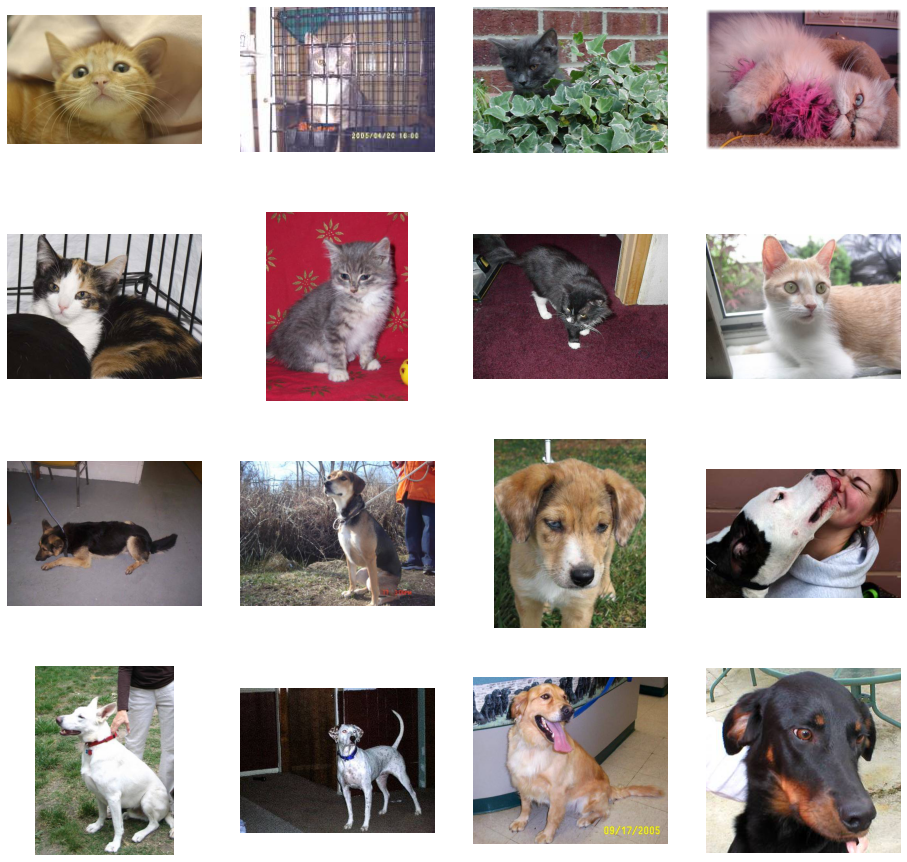

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8 # 인덱스 +8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch to Get to ~72% Accuracy

위의 이미지를 보면 모양과 크기가 다양한 것을 볼 수 있다. 이를 신경망이 훈련할 수 있도록 처리하려면 크기가 균일해야하므로 이미지를 150x150으로 사전처리한다.



In [10]:
import tensorflow as tf

Sequential layer를 정의하고 Convolutional layer를 추가한다. 이미지는 150x150이고 color depth는 3(24비트, 3바이트)이다. 이진 분류 문제이므로 네트워크의 출력이 0과 1 사이의 단일 스칼라가 되도록 sigmoid 활성화함수를 사용하고 다음 확률을 인코딩한다.

In [11]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    # Conv2D(filters, kernel_size)
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
                                    tf.keras.layers.MaxPool2D(2,2),
                                    # Flatten the result to feed into a DNN
                                    tf.keras.layers.Flatten(),
                                    # 512 neuron hidden layer
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    # Only 1 output neuron. 
                                    #It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
                                    tf.keras.layers.Dense(1, activation='sigmoid')                                  
])

model.summary()로 NN 요약을 프린트할 수 있다.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

"출력 모양" 열은 각 연속 레이어에서 피쳐 맵의 크기가 어떻게 발전하는지 보여준다. 컨볼루션 레이어는 패딩으로 인해 피쳐 맵의 크기를 약간 줄이고 각 풀링 레이어는 차원을 절반으로 줄인다.


바이너리 분류 문제이고 최종 활성화가 시그모이드이기 때문에 binary_crossentropy 손실로 모델을 훈련한다. 학습률이 0.001인 rmsprop 옵티마이저를 사용한다. 훈련 중에 분류 정확도를 모니터링한다.

*RMSprop이 학습률 조정을 자동화하기 때문에 RMSprop 최적화 알고리즘을 사용하는 것이 확률적 경사하강법(SGD)보다 선호된다. (Adam 및 Adagrad와 같은 다른 최적화 프로그램도 훈련 중에 학습률을 자동으로 조정하며 똑같이 잘 동작한다.)*

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Data Preprocessing

이미지를 읽어서 `float32` tensor로 변환한 다음 레이블과 함께 네트워크에 공급하는 data generator를 설정한다. 훈련 이미지를 위한 generator와 검증 이미지를 위한 generator를 하나씩 생성한다. generator는 150x150 크기 이미지 20개와 해당 레이블(바이너리)을 생성한다.

신경망에 들어가는 데이터는 일반적으로 정규화되어 네트워크에서 처리하기 쉽게 만들어야한다.(raw 픽셀을 convnet에 공급하는 것은 드물다.)픽셀 값을 [0, 1] 범위(원래 모든 값은 [0, 255] 범위에 있음)로 정규화하여 이미지를 전처리한다.

증강 이미지 배치(및 해당 레이블)의 생성기를 인스턴스화할 수 있다. 그런 다음 이러한 생성기를 입력으로 데이터 생성기를 허용하는 Keras 모델 메서드(fit, evaluate_generator 및 predict_generator)와 함께 사용할 수 있다.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

#--------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training

2000개 이미지를 모두 15 epoch 동안 학습하고 1000개 이미지를 유효성 검증에 사용한다.
*실행하는데 몇분 걸림*

epoch당 4개의 값(손실, 정확도, 유효성 검사 손실, 유효성 검사 정확도)이 표시된다.

Loss and Accuracy는 훈련 진행 상황을 잘 보여준다. 훈련 데이터의 분류를 추측하고 알려진 레이블과 비교하여 측정하여 결과를 계산한다. 정확도는 정확한 추측의 부분입니다. 검증 정확도는 훈련에 사용되지 않은 데이터로 측정한다.(예상대로 약간 낮다.) 이 과정의 뒷부분에 나오는 과적합 섹션에서 왜 이런 일이 발생하는지 배운다.

In [15]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_steps=50,
                    verbose=2)

Epoch 1/15
100/100 - 59s - loss: 0.8026 - accuracy: 0.5445 - val_loss: 0.6615 - val_accuracy: 0.6000 - 59s/epoch - 589ms/step
Epoch 2/15
100/100 - 57s - loss: 0.6516 - accuracy: 0.6470 - val_loss: 0.6430 - val_accuracy: 0.6290 - 57s/epoch - 571ms/step
Epoch 3/15
100/100 - 57s - loss: 0.5835 - accuracy: 0.7195 - val_loss: 0.6355 - val_accuracy: 0.6920 - 57s/epoch - 575ms/step
Epoch 4/15
100/100 - 57s - loss: 0.4778 - accuracy: 0.7855 - val_loss: 0.6020 - val_accuracy: 0.7230 - 57s/epoch - 572ms/step
Epoch 5/15
100/100 - 57s - loss: 0.3565 - accuracy: 0.8380 - val_loss: 0.8720 - val_accuracy: 0.6250 - 57s/epoch - 572ms/step
Epoch 6/15
100/100 - 57s - loss: 0.2776 - accuracy: 0.8930 - val_loss: 0.7554 - val_accuracy: 0.7160 - 57s/epoch - 574ms/step
Epoch 7/15
100/100 - 58s - loss: 0.1840 - accuracy: 0.9245 - val_loss: 0.9971 - val_accuracy: 0.7030 - 58s/epoch - 576ms/step
Epoch 8/15
100/100 - 57s - loss: 0.1268 - accuracy: 0.9510 - val_loss: 1.1070 - val_accuracy: 0.7070 - 57s/epoch - 573

## Running the Model
모델을 사용하여 실제로 예측을 실행하는 방법이다. 아래 코드를 사용하면 파일 시스템에서 하나 이상의 파일을 선택할 수 있다. 그런 다음 파일을 업로드하고 모델을 통해 개체가 개인지 고양이인지 표시한다.

Important Note: Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a Colab on the Safari browser. For all other broswers, continue with the next code block and ignore the next one after it.

The ones running the Colab on Safari, comment out the code block below, uncomment the next code block and run it.


Saving cat_test.jpeg to cat_test (1).jpeg


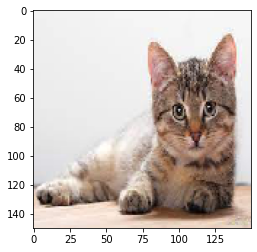

[0.]
cat_test.jpeg is a cat


In [19]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  
  #  show image
  plt.imshow(img) 
  plt.show()
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])
  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

In [ ]:
#import numpy as np
#from keras.preprocessing import image
#import os
#
#images = os.listdir("./cats_and_dogs_filtered")
#print(images)
#
#for i in images:
#  print()
# # predicting images
#  path = './cats_and_dogs_filtered/' + i
#  img = image.load_img(path, target_size=(150, 150))
#  x = image.img_to_array(img)
#  x = np.expand_dims(x, axis=0)
#
#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a dog")
#  else:
#    print(i + " is a cat")

## Visualizing Intermediate Representations

convnet을 통과할 때 어떻게 변환되는지 시각화한다. 훈련 세트에서 임의의 고양이 혹은 개 이미지를 선택한 다음 각 행이 레이어의 출력이고 행의 각 이미지가 해당 출력 기능 맵의 특정 필터인 그림을 생성한다.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


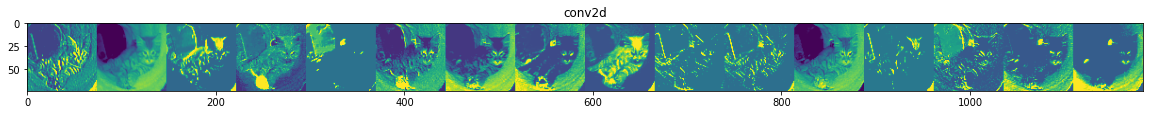

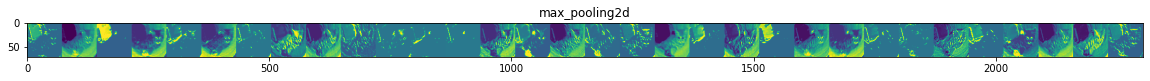

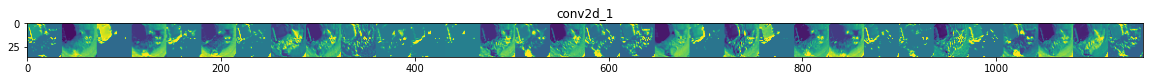

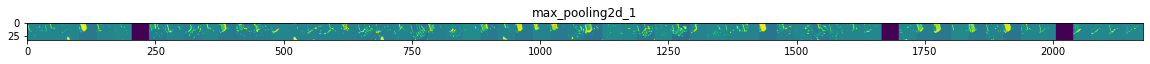

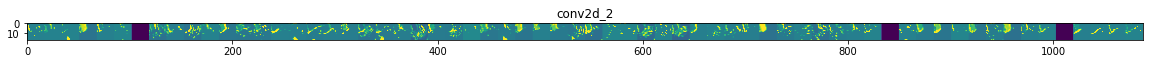

In [20]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x #가시성을 위해서 처리, Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

이미지의 raw 픽셀에서 점점 **더 추상적이고 간결한 표현으로 이동**한다. 다운스트림 표현은 네트워크가 주목하는 것을 강조하기 시작하고 "활성화"되는 기능이 점점 더 적어진다. 대부분은 0으로 설정된다. 이것을 **"sparsity, 희소성"**이라고 한다. 표현 희소성은 딥 러닝의 핵심 기능이다.

이러한 표현은 이미지의 원래 픽셀에 대한 정보는 점점 줄어들지만 이미지 클래스에 대한 정보는 점점 더 정교해진다. convnet(또는 일반적으로 딥 네트워크)을 정보 증류 파이프라인으로 생각할 수 있다.

## Evaluating Accuracy and Loss for the Model

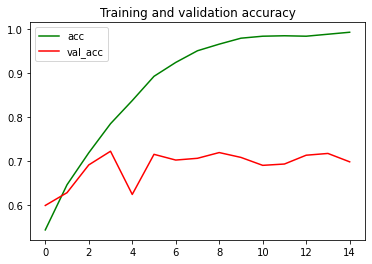

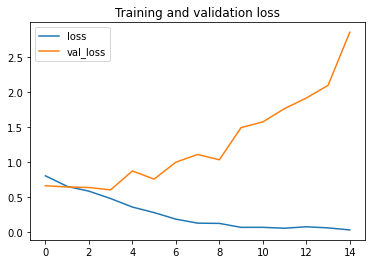

In [27]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='acc', color='g' )
plt.plot  ( epochs, val_acc, label='val_acc', color='r')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='loss' )
plt.plot  ( epochs, val_loss, label='val_loss' )
plt.title ('Training and validation loss'   )
plt.legend()

위의 그래프를 보명 학습데이터에 과적합되고 있는 것을 알 수 있다. 훈련 정확도(초록색, acc)는 100%에 가까워지고 검증 정확도(빨간색, val_acc)는 70%에 머무른다. 검증 손실(주황색, val_loss)은 5개의 Epoch 후에 최소값에 도달한다.

상대적으로 적은 수의 훈련 예제(2000개)가 있으므로 과적합이 가장 중요한 문제이다. 과적합은 너무 적은 수의 예제에 노출된 모델이 새로운 데이터로 일반화되지 않는 패턴을 학습할 때 발생한다. **즉, 모델이 예측을 위해 관련 없는 기능을 사용하기 시작할 때 발생한다.**

과적합은 머신 러닝의 핵심 문제다. 주어진 데이터 세트에 모델의 매개변수를 맞추는 경우 모델이 학습한 표현을 이전에 볼 수 없었던 데이터에 적용할 수 있도록 하려면 어떻게 해야 할까? 다음 연습에서는 cat vs dog 분류 모델에서 과적합을 방지하는 방법을 살펴본다.

## Clean Up

다음 연습을 실행하기 전에 다음 셀을 실행하여 커널을 종료하고 메모리 리소스를 해제한다.


In [ ]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGKILL
       )